## Library imports

In [69]:
#Import all the necessary libraries and store data in Dataframe
import pandas as pd
import kagglehub
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import matplotlib as mt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
import  xgboost as xgb
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
#from skimpy import skim, generate_test_data
# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)


df = pd.read_csv(path + '/healthcare-dataset-stroke-data.csv')
df_stroke = df.copy()

df_stroke.head()

Path to dataset files: C:\Users\gamer\.cache\kagglehub\datasets\fedesoriano\stroke-prediction-dataset\versions\1


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


###About Dataset:
1) id: subject ID number
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have heart disease, 1 if the patient has heart 
disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_job", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" o("Unknown" in smoking_status means that the information is unavailable)
13Unknown"
12) stroke: 1 if the patient  or 0 if nothad a st this patient


# Data Preprocessing

To achieve meaningful and accurate results, data preprocessing is a crucial first step. This involves cleaning the data, handling missing values, encoding categorical variables, and removing redundant columns.

Our dataset consists of 12 columns and 5,110 records, some of which contain unnecessary or incomplete information, making cleaning essential.


•	Missing Values: The BMI field contains missing values, which were imputed using the MICE (Multiple Imputation by Chained Equations) technique to ensure accuracy and completeness.

•	Encoding Categorical Variables: One-hot encoding was applied to all categorical variables using pd.get_dummies(), creating separate columns for each category.

•	Reducing Dimensions: After encoding, redundant columns that provided the same information were removed to reduce dataset dimensions. Examples include: \n
    1) Gender_Male and Gender_Female columns: One was removed as they convey the same information. \n
    2) Ever_married_Yes and Ever_married_No columns: One was eliminated to avoid redundancy. \n
    3) Id column: Removed as it is irrelevant to the analysis. \n


In [70]:
#Since we have only 1 row with other gender removing this row
df_stroke=df_stroke[df_stroke['gender']!='Other']
# Since ID is not useful removing it
df_stroke = df_stroke.drop(['id'], axis = 1)
df_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Check if there are any missing or null values in the dataset

In [71]:
df_stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We can observe the bmi contains 201 null values in the dataset which is 3% of the data

Since it is a numerical value check if data is is normally distributed to apply mean else apply median.

<Axes: xlabel='bmi', ylabel='Count'>

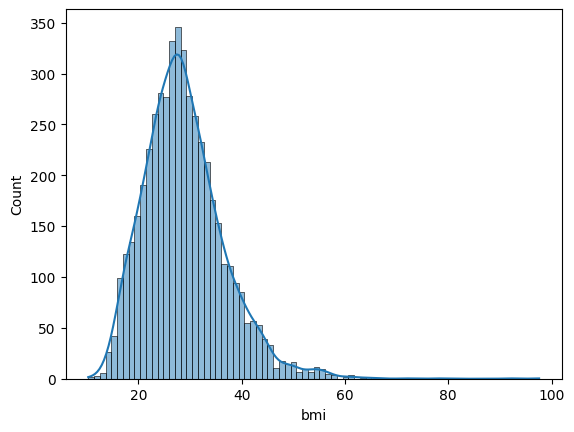

In [72]:
#BMI Distribution
sns.histplot(x='bmi',data=df_stroke,kde=True)
#Data is skewed hence apply median or mice imputation

In [73]:
print(f"BMI: Min->{df_stroke['bmi'].min()} \t Max->{df_stroke['bmi'].max()} \n Mean -> {df_stroke['bmi'].mean()} \n Median-> {df_stroke['bmi'].median()} \n Mode -> {df_stroke['bmi'].mode()[0]}")

BMI: Min->10.3 	 Max->97.6 
 Mean -> 28.894559902200488 
 Median-> 28.1 
 Mode -> 28.7


In [74]:
#MICE imputation for BMI
# need to enable iterative imputer explicitly since its still experimental
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
#imputer = IterativeImputer(random_state=100, max_iter=10)
df_train= df_stroke.loc[:,['age','avg_glucose_level','bmi']]
df_train.head()


imputer=IterativeImputer(estimator=RandomForestRegressor(random_state=100),random_state=100)
imputer.fit(df_train)
df_imputed = imputer.transform(df_train)
df_imputed
df_stroke.loc[:,['age','avg_glucose_level','bmi']] = df_imputed
df_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,37.033,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,26.958,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600,formerly smoked,0


<Axes: xlabel='bmi', ylabel='Count'>

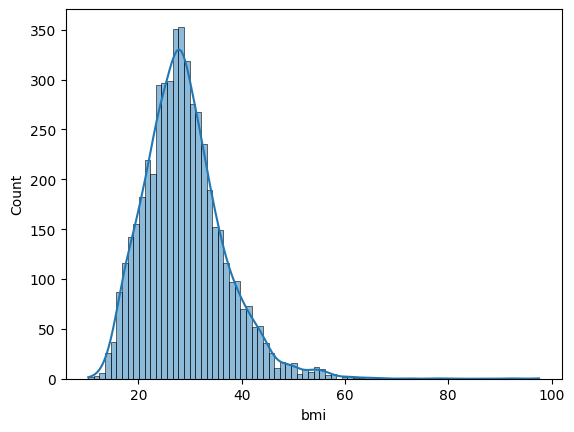

In [75]:
#BMI Distribution after mice imputation
sns.histplot(x='bmi',data=df_stroke,kde=True)
#

In [76]:
print(f"BMI: Min->{df_stroke['bmi'].min()} \t Max->{df_stroke['bmi'].max()} \n Mean -> {df_stroke['bmi'].mean()} \n Median-> {df_stroke['bmi'].median()} \n Mode -> {df_stroke['bmi'].mode()[0]}")

BMI: Min->10.3 	 Max->97.6 
 Mean -> 28.944337427881706 
 Median-> 28.2 
 Mode -> 28.7


<Axes: xlabel='age', ylabel='Count'>

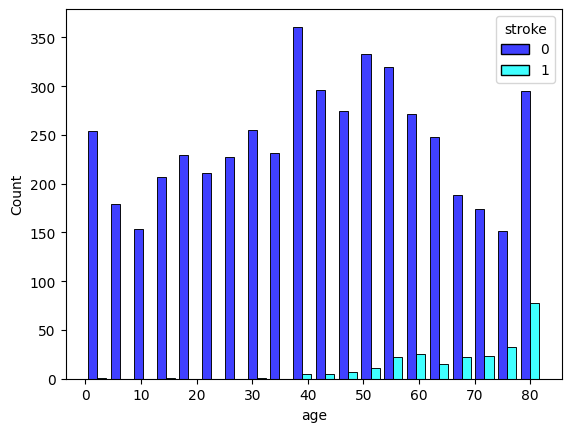

In [77]:
#Age Vs Stroke DISTRIBUTION
custom_palette = {0: 'blue', 1: 'cyan'}
sns.histplot(x='age',hue='stroke',stat='count',binwidth=4,data=df_stroke,palette=custom_palette,multiple='dodge',shrink=0.8)

<Axes: xlabel='age', ylabel='Count'>

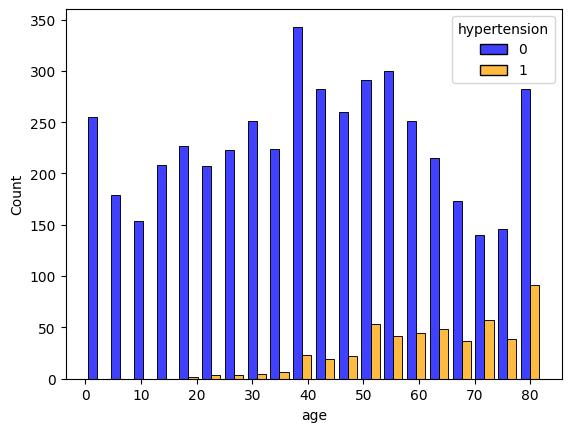

In [78]:
#Age Vs hypertension DISTRIBUTION
custom_palette = {0: 'blue', 1: 'orange'}
sns.histplot(x='age',hue='hypertension',stat='count',binwidth=4,data=df_stroke,palette=custom_palette,multiple='dodge',shrink=0.8)

<Axes: xlabel='age', ylabel='Count'>

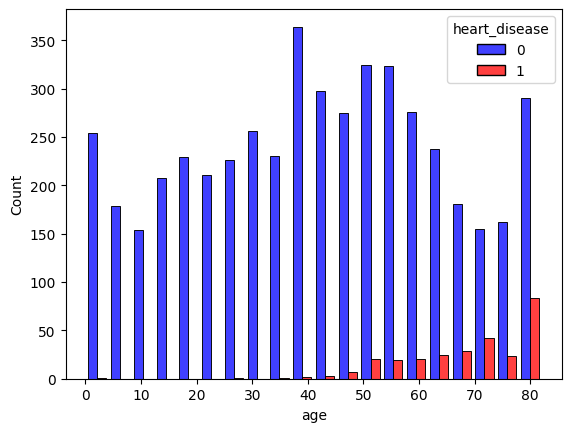

In [79]:
#Age Vs heart_disease DISTRIBUTION
custom_palette = {0: 'blue', 1: 'red'}
sns.histplot(x='age',hue='heart_disease',stat='count',binwidth=4,data=df_stroke,palette=custom_palette,multiple='dodge',shrink=0.8)

<Axes: xlabel='age', ylabel='avg_glucose_level'>

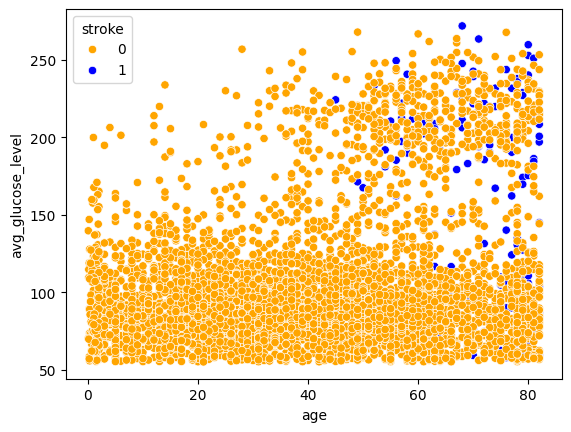

In [80]:
#AGE Vs Avg_Glucose_Level Vs Stroke
custom_palette = {1:"blue",0:"orange"}
sns.scatterplot(x='age',y='avg_glucose_level',hue='stroke',data=df_stroke,palette=custom_palette,sizes=[0.3,0.9])
                #,stat='count',binwidth=4,data=df_stroke,palette=custom_palette,multiple='dodge',shrink=0.8)

<Axes: xlabel='bmi', ylabel='Count'>

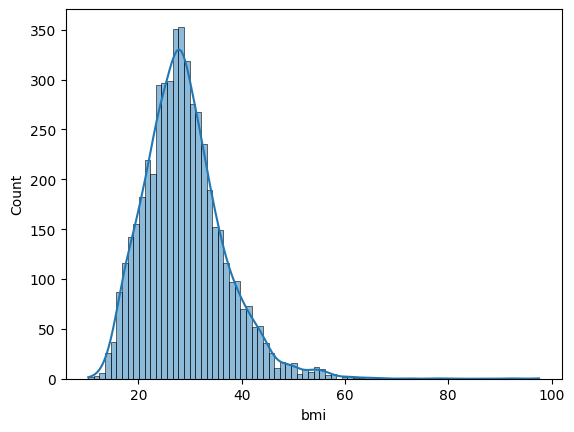

In [81]:
#BMI Distribution after MICE Imputation
sns.histplot(x='bmi',data=df_stroke,kde=True)

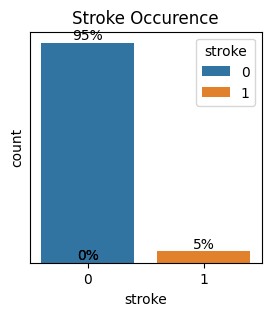

In [82]:
#Stroke Distribution
plt.figure(figsize=(3,3))
ax=sns.countplot(x='stroke',hue='stroke',data=df_stroke)

ax.set_yticks([])
plt.title("Stroke Occurence")
total=df_stroke['stroke'].count()
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/total, '.0f')+'%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

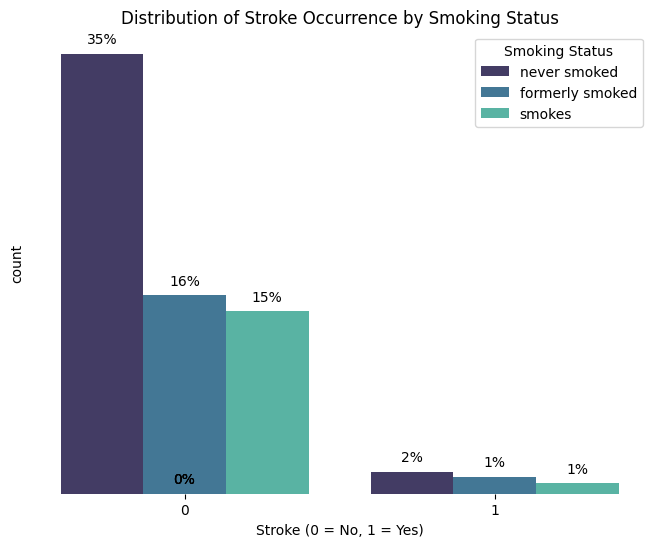

In [83]:
#Distribution of Stroke Occurrence by Smoking Status
plt.figure(figsize=(8, 6))

ax=sns.countplot(x='stroke', hue='smoking_status',hue_order = ['never smoked','formerly smoked', 'smokes'],
                 stat='count',palette="mako",data=df_stroke,legend="brief")

ax.set_yticks([])
plt.title('Distribution of Stroke Occurrence by Smoking Status')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
#plt.ylabel('Count')
plt.legend(title='Smoking Status')
for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
total=df['id'].count()
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/total, '.0f')+'%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

C:\Users\gamer\AppData\Local\Temp\ipykernel_8816\3191471225.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels( labels = ['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'],fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})
C:\Users\gamer\AppData\Local\Temp\ipykernel_8816\3191471225.py:67: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_stroke, x = 'age', ax = ax2, shade = True, color = '#2c003e',alpha = 1, )
C:\Users\gamer\AppData\Local\Temp\ipykernel_8816\3191471225.py:83: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data = df_stroke[df_stroke['stroke'] == 0], x = 'age',ax = ax3, shade = True,

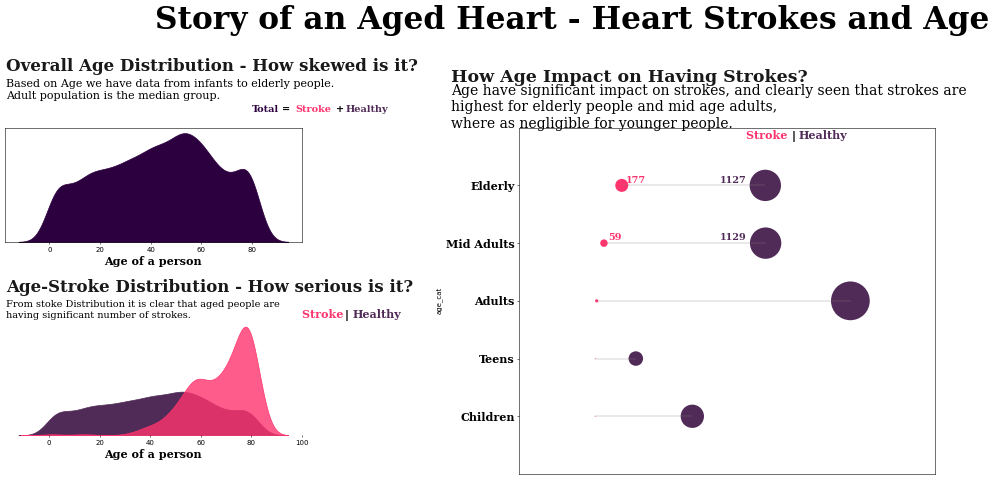

In [84]:

df_stroke['bmi_cat'] = pd.cut(df_stroke['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
df_stroke['age_cat'] = pd.cut(df_stroke['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
df_stroke['glucose_cat'] = pd.cut(df_stroke['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

fig = plt.figure(figsize = (24,10), dpi = 50)

gs = fig.add_gridspec(10,24)
gs.update(wspace = 1, hspace = 0.05)


ax2 = fig.add_subplot(gs[1:4,0:8]) #distribution plot
ax3 = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot
ax1 = fig.add_subplot(gs[1:10,13:]) #dumbbell plot

# axes list
axes = [ ax1,ax2, ax3]

# setting of axes; visibility of axes and spines turn off
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    #ax.set_facecolor('#f6f5f5')
    
for loc in ['left', 'right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)

#fig.patch.set_facecolor('#f6f5f5')
        
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(True)

# dumbbell plot of stoke and healthy people

stroke_age = df_stroke[df_stroke['stroke'] == 1].age_cat.value_counts()
healthy_age = df_stroke[df_stroke['stroke'] == 0].age_cat.value_counts()

ax1.hlines(y = ['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'], xmin = [644,270,1691,1129,1127], 
          xmax = [1,1,11,59,177], color = 'grey',**{'linewidth':0.5})


sns.scatterplot(y = stroke_age.index, x = stroke_age.values, s = stroke_age.values*2, color = '#fe346e', ax= ax1, alpha = 1)
sns.scatterplot(y = healthy_age.index, x = healthy_age.values, s = healthy_age.values*2, color = '#512b58', ax= ax1, alpha = 1)

ax1.axes.get_xaxis().set_visible(False)
ax1.set_xlim(xmin = -500, xmax = 2250)
ax1.set_ylim(ymin = -1,ymax = 5)

ax1.set_yticklabels( labels = ['Children', 'Teens', 'Adults', 'Mid Adults', 'Elderly'],fontdict = {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

ax1.text(-950,5.8, 'How Age Impact on Having Strokes?' ,{'font': 'Serif', 'size': '25','weight':'bold', 'color':'black'},alpha = 0.9)
ax1.text(1000,4.8, 'Stroke ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax1.text(1300,4.8, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax1.text(1350,4.8, 'Healthy', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})
ax1.text(-950,5., 'Age have significant impact on strokes, and clearly seen that strokes are \nhighest for elderly people and mid age adults, \nwhere as negligible for younger people.', 
        {'font':'Serif', 'size':'20','color': 'black'})

ax1.text(stroke_age.values[0] + 30,4.05, stroke_age.values[0], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#fe346e'})
ax1.text(healthy_age.values[2] - 300,4.05, healthy_age.values[2], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#512b58'})

ax1.text(stroke_age.values[1] + 30,3.05, stroke_age.values[1], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#fe346e'})
ax1.text(healthy_age.values[1] - 300,3.05, healthy_age.values[1], {'font':'Serif', 'size':14, 'weight':'bold', 'color':'#512b58'})




# distribution plots ---- only single variable

sns.kdeplot(data = df_stroke, x = 'age', ax = ax2, shade = True, color = '#2c003e',alpha = 1, )
ax2.set_xlabel('Age of a person', fontdict = {'font':'Serif', 'color': 'black', 'size': 16,'weight':'bold' })
ax2.text(-17,0.025,'Overall Age Distribution - How skewed is it?', {'font':'Serif', 'color': 'black','weight':'bold','size':24}, alpha = 0.9)
ax2.text(-17,0.021, 'Based on Age we have data from infants to elderly people.\nAdult population is the median group.', 
        {'font':'Serif', 'size':'16','color': 'black'})
ax2.text(80,0.019, 'Total',{'font':'Serif', 'size':'14','color': '#2c003e','weight':'bold'})
ax2.text(92,0.019, '=',{'font':'Serif', 'size':'14','color': 'black','weight':'bold'})
ax2.text(97,0.019, 'Stroke',{'font':'Serif', 'size':'14','color': '#fe346e','weight':'bold'})
ax2.text(113,0.019, '+',{'font':'Serif', 'size':'14','color': 'black','weight':'bold'})
ax2.text(117,0.019, 'Healthy',{'font':'Serif', 'size':'14','color': '#512b58','weight':'bold'})



# distribution plots with hue of strokes


sns.kdeplot(data = df_stroke[df_stroke['stroke'] == 0], x = 'age',ax = ax3, shade = True,  alpha = 1, color = '#512b58' )
sns.kdeplot(data = df_stroke[df_stroke['stroke'] == 1], x = 'age',ax = ax3, shade = True,  alpha = 0.8, color = '#fe346e')

ax3.set_xlabel('Age of a person', fontdict = {'font':'Serif', 'color': 'black', 'weight':'bold','size': 16})

ax3.text(-17,0.0525,'Age-Stroke Distribution - How serious is it?', {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}, alpha= 0.9)
ax3.text(-17,0.043,'From stoke Distribution it is clear that aged people are \nhaving significant number of strokes.', {'font':'Serif', 'color': 'black', 'size':14})
ax3.text(100,0.043, 'Stroke ', {'font': 'Serif','weight':'bold','size': '16','weight':'bold','style':'normal', 'color':'#fe346e'})
ax3.text(117,0.043, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
ax3.text(120,0.043, 'Healthy', {'font': 'Serif','weight':'bold', 'size': '16','style':'normal', 'weight':'bold','color':'#512b58'})

fig.text(0.25,1,'Story of an Aged Heart - Heart Strokes and Age',{'font':'Serif', 'weight':'bold','color': 'black', 'size':45})
fig.show()

In [85]:
#We just created this columns for our plots for gaining the better understanding
#Remove them as we dont need further.
df_stroke = df_stroke.drop('bmi_cat',axis=1)
df_stroke = df_stroke.drop('age_cat',axis=1)
df_stroke = df_stroke.drop('glucose_cat',axis=1)

C:\Users\gamer\AppData\Local\Temp\ipykernel_8816\3710896729.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


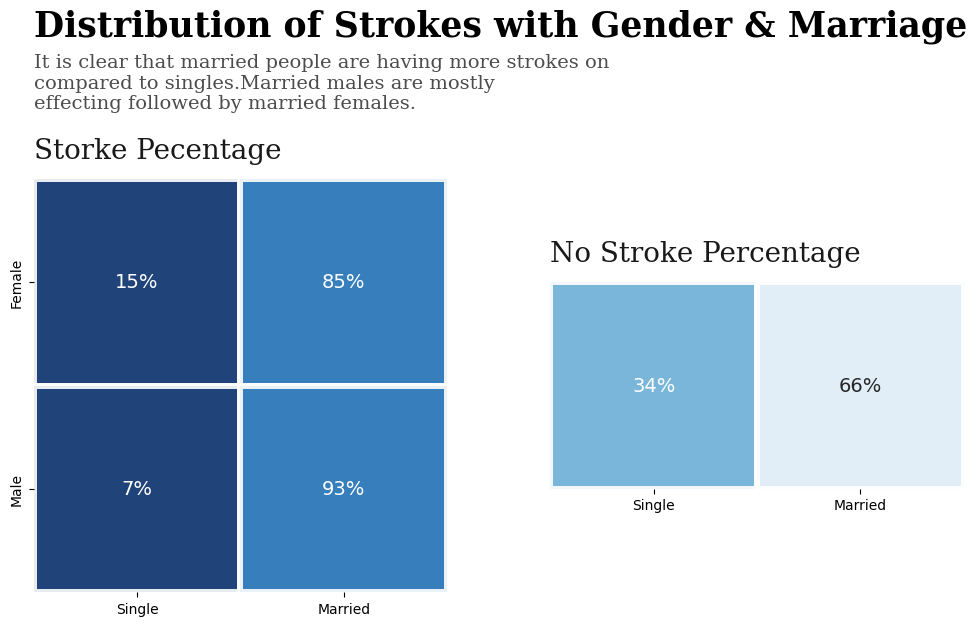

In [86]:
import matplotlib

fig = plt.figure(figsize=(12,6),dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])



# ever_married, gender, residence, heart_disease and work_type

healthy = df_stroke[df_stroke['stroke']==0]
stroke = df_stroke[df_stroke['stroke']==1]


col1 = ["#08306b","#2171b5"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N = 256)
col2 = ["#6baed6","#deebf7"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

stroke = pd.crosstab(stroke['gender'],[stroke['ever_married']],normalize='index')
no_stroke = pd.crosstab(healthy['gender'],[healthy['ever_married']], normalize='index')

sns.heatmap(ax=ax0, data=stroke, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col1,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=no_stroke[0:-1], linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, cmap = col2,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

ax0.text(0, -0.69, 'Distribution of Strokes with Gender & Marriage', {'font':'Serif', 'color':'black', 'weight':'bold','size':25})
ax0.text(0, -0.34, 'It is clear that married people are having more strokes on \ncompared to singles.Married males are mostly \neffecting followed by married females.', {'font':'Serif', 'color':'black','size':14}, alpha = 0.7)

ax0.text(0,-0.1,'Storke Pecentage ', {'font':'serif', 'color':"black", 'size':20},alpha = 0.9)
ax1.text(0,-0.1,'No Stroke Percentage', {'font':'serif', 'color':"black", 'size':20}, alpha =0.9)

ax0.axes.set_xticklabels(['Single', 'Married'])
ax1.axes.set_xticklabels(['Single', 'Married'])

ax0.axes.set_yticklabels(['Female', 'Male'])


ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()


In [87]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


<Axes: xlabel='avg_glucose_level'>

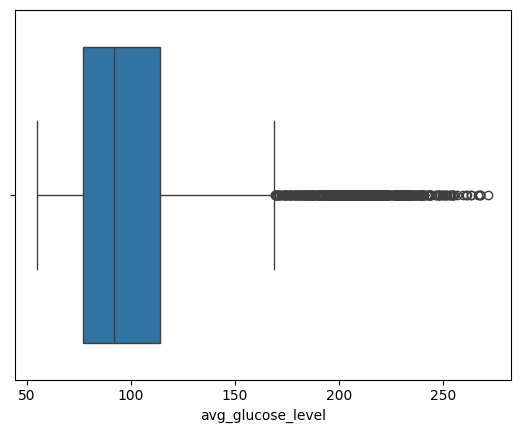

In [88]:
#Outliers exist for avg_glucose_level which needs to be handled
sns.boxplot(x='avg_glucose_level',data=df_stroke)

<Axes: xlabel='age', ylabel='bmi'>

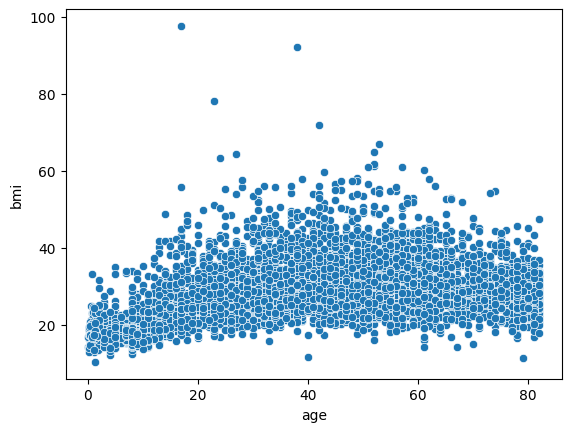

In [89]:
#Outliers exist for bmi which needs to be handled before proceeding with model building

sns.scatterplot(data= df_stroke, x= 'age',y='bmi',legend='brief')

From above scatterplot we can see the BMI distribution across all the age groups in the given data.
In General Healthy BMI ranges from 18.5 to 24.9.However we can the most of the data indicates BMI >25 which is a clear indication that people are obese and following unhealthy lifestyle, infuture they may be affected with any kind of diseases ex:Stroke,Heart Disease.


In [90]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [91]:
#Perform one hot encoding for all the categorical values and reduce the dimensionality by removing columns which are not useful for our model
import numpy as np
from sklearn.preprocessing import OneHotEncoder

df_enc = pd.get_dummies(df_stroke,columns=['gender','ever_married','work_type','Residence_type','smoking_status'])
df_enc.columns


Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Female', 'gender_Male', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'Residence_type_Rural', 'Residence_type_Urban',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [92]:

df_enc=df_enc.drop(['gender_Female','ever_married_No','work_type_Never_worked','work_type_children','Residence_type_Rural','smoking_status_Unknown'],axis=1)
#df_enc=df_enc.drop(['gender_Female','ever_married_No','Residence_type_Rural'],axis=1)
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   gender_Male                     5109 non-null   bool   
 7   ever_married_Yes                5109 non-null   bool   
 8   work_type_Govt_job              5109 non-null   bool   
 9   work_type_Private               5109 non-null   bool   
 10  work_type_Self-employed         5109 non-null   bool   
 11  Residence_type_Urban            5109 non-null   bool   
 12  smoking_status_formerly smoked  5109 no

In [93]:
#Scaling
df_enc['age'] = df_enc['age'].apply(lambda x: np.log(x+10)*3)
df_enc['avg_glucose_level'] = df_enc['avg_glucose_level'].apply(lambda x: np.log(x+10)*2)
df_enc['bmi'] = df_enc['bmi'].apply(lambda x: np.log(x+10)*2)



C:\Users\gamer\AppData\Local\Temp\ipykernel_8816\841845.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


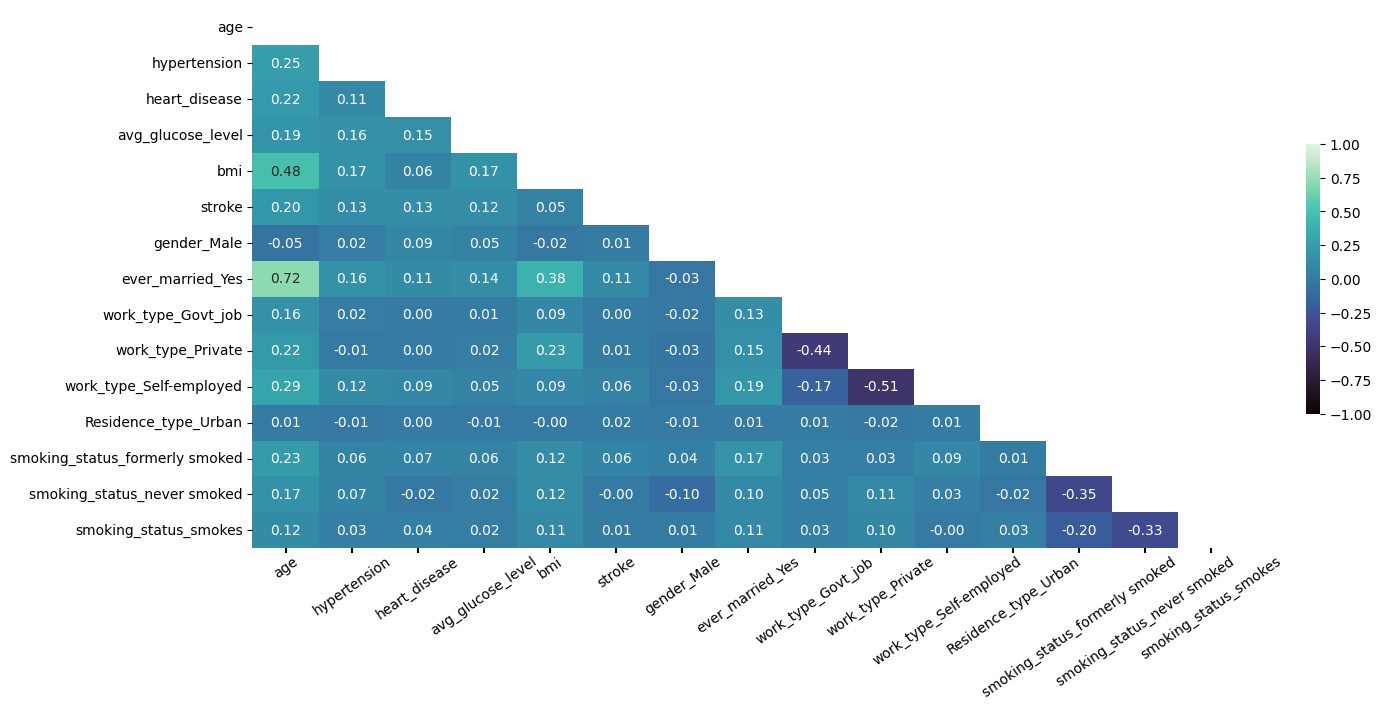

In [94]:
#Scale -1 to +1 for correlation 
import numpy as np
corr = df_enc.corr()
matrix = np.triu(corr)
fig, ax = plt.subplots(figsize = (16,7))
#plt.figure(figsize = (16,7))

sns.heatmap(corr,cmap = 'mako',  annot=True, mask=matrix, fmt=".2f",
           vmin=-1, vmax=1, cbar_kws={"shrink": .5, })
ax.tick_params(axis = 'x', width=1.5,pad=0.5,rotation=35)
fig.show()

In [95]:
#Split the data into training and testing 

df_model = df_enc
X=df_model.drop('stroke',axis=1)
y=df_model['stroke']

#Split the data into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=53)

print("Train",X_train.shape,y_train.shape)
print("Test",X_test.shape,y_test.shape)

Train (3576, 14) (3576,)
Test (1533, 14) (1533,)


In [96]:
def prepare_data(X_train,X_test):
    object_columns = X_train.select_dtypes(include=["object"]).columns
    X_train_enc = X_train
    X_test_enc = X_test
    oe = OrdinalEncoder()
    oe.fit(X_train[object_columns])
    X_train_enc[object_columns] = oe.transform(X_train[object_columns])
    X_test_enc[object_columns] = oe.transform(X_test[object_columns])
    return X_train_enc,X_test_enc

In [97]:
def prepare_Target(y_train,y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc,y_test_enc

In [98]:
#Perform different encoding techniques for the data
X_train_enc,X_test_enc = prepare_data(X_train,X_test)
y_train_enc,y_test_enc = prepare_Target(y_train,y_test)

In [99]:
#Before SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "xgBoost":xgb.XGBClassifier()

}


for name,model in models.items():
    #Train the model
    model.fit(X_train_enc,y_train_enc)
    #get the predicted probabilities
    y_prob = model.predict_proba(X_test_enc)[:,1]
    y_pred = (y_prob>0.5).astype(int)
    #Evaluate the model on training dataset
    print(f"\t..............................{name}..................................\n")
    print("----------------------------This is prediction on same trained data-------------------------------------")
    y_pred_trainTest = model.predict(X_train_enc)
    print("Confusion Matrix:\n", confusion_matrix(y_train_enc, y_pred_trainTest))
    print("\nClassification Report:\n", classification_report(y_train_enc, y_pred_trainTest))

    print("----------------------------This is prediction on testing data-------------------------------------")
    # Evaluate the model on testing dataset
    print("Confusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))
    print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))
    




	..............................Logistic Regression..................................

----------------------------This is prediction on same trained data-------------------------------------
Confusion Matrix:
 [[2442  960]
 [  25  149]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83      3402
           1       0.13      0.86      0.23       174

    accuracy                           0.72      3576
   macro avg       0.56      0.79      0.53      3576
weighted avg       0.95      0.72      0.80      3576

----------------------------This is prediction on testing data-------------------------------------
Confusion Matrix:
 [[1023  435]
 [  13   62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.70      0.82      1458
           1       0.12      0.83      0.22        75

    accuracy                           0.71      1533
   macro avg       0.5

ROC-AUC: 0.49912208504801103


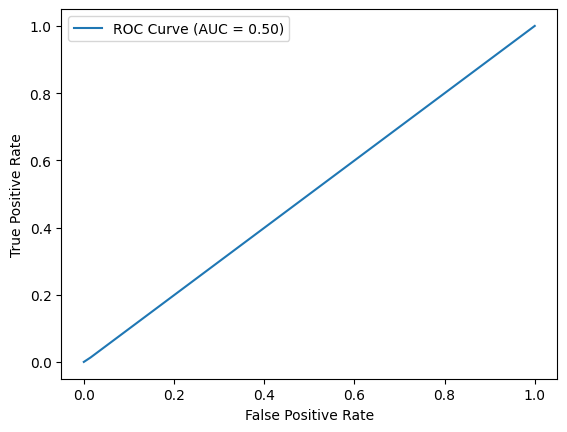

In [100]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC-AUC
roc_auc = roc_auc_score(y_test_enc, y_pred)
print("ROC-AUC:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_enc, y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


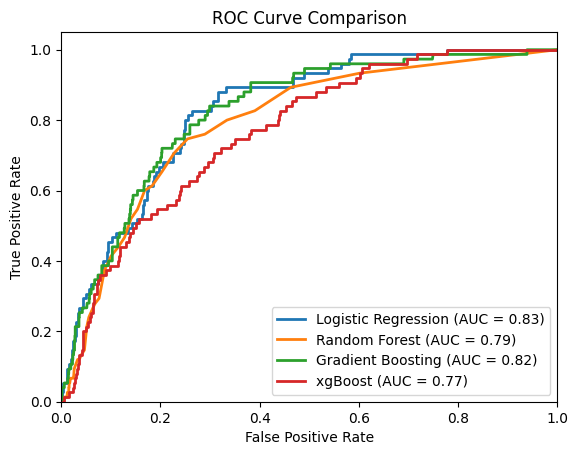

,Accuracy,Precision,Recall,AUC_Score
Logistic Regression,0.707763,0.124748,0.826667,0.827526
Random Forest,0.948467,0.000000,0.000000,0.792327
Gradient Boosting,0.951076,0.500000,0.040000,0.823297
xgBoost,0.937378,0.043478,0.013333,0.767590


In [106]:
# Lets intiate our models for accuracy
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "xgBoost":xgb.XGBClassifier()

}

# create empty dictionaries for scores
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
auc_scores = {}


# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_enc, y_train_enc)
    
    # Predict probabilities for test set
    y_pred_proba = model.predict_proba(X_test_enc)[:, 1]
    y_pred = model.predict(X_test_enc)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_enc, y_pred_proba)

    # Calculate metrics
    accuracy_scores[name] = accuracy_score(y_test_enc, y_pred)
    precision_scores[name] = precision_score(y_test_enc, y_pred)
    recall_scores[name] = recall_score(y_test_enc, y_pred)
    auc_scores[name] = roc_auc_score(y_test_enc, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_scores[name]:.2f})')




# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

comparision =  pd.DataFrame({
    "Accuracy":accuracy_scores,
    "Precision":precision_scores,
    "Recall":recall_scores,
    "AUC_Score":auc_scores
})
comparision

## SMOTE 

In [102]:
#Applying SMOTE(Synthetic Minority Oversampling Technique) technique helps us to balance the imbalance data
oversample = SMOTE()
X_smote,y_smote=oversample.fit_resample(X_train_enc,y_train_enc)

In [103]:
# Logistic Regression model
from sklearn.metrics import *

models = {
    "Logistic Regression": LogisticRegression(max_iter=2500),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}


for name,model in models.items():
    model.fit(X_smote,y_smote)
    y_pred = model.predict(X_test_enc)
    print(f"Accuracy using {name}:",round(accuracy_score(y_test_enc,y_pred),2))
    print(f"confusion matrix using {name}:\n",confusion_matrix(y_test_enc,y_pred))
    print(f"Classification report for {name}:\n",classification_report(y_test_enc,y_pred))
    print("---------------------------------------------------------------------------------------------")



Accuracy using Logistic Regression: 0.72
confusion matrix using Logistic Regression:
 [[1048  410]
 [  23   52]]
Classification report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.98      0.72      0.83      1458
           1       0.11      0.69      0.19        75

    accuracy                           0.72      1533
   macro avg       0.55      0.71      0.51      1533
weighted avg       0.94      0.72      0.80      1533

---------------------------------------------------------------------------------------------
Accuracy using Random Forest: 0.87
confusion matrix using Random Forest:
 [[1332  126]
 [  66    9]]
Classification report for Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      1458
           1       0.07      0.12      0.09        75

    accuracy                           0.87      1533
   macro avg       0.51      0.52      0.51      1533
wei

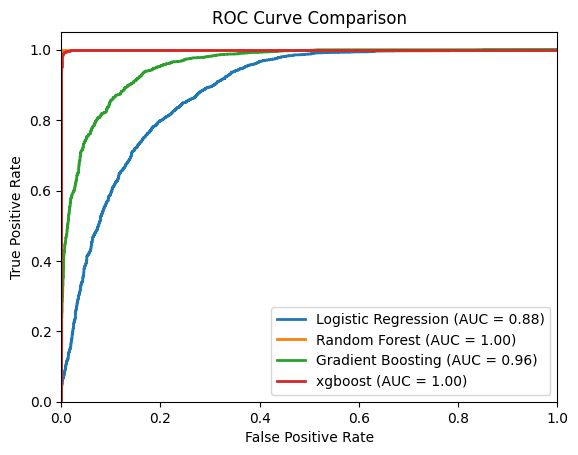

After Handling Imbalance Data ::



,Accuracy,Precision,Recall,AUC_Score
Logistic Regression,0.799530,0.768440,0.857437,0.881701
Random Forest,1.000000,1.000000,1.000000,1.000000
Gradient Boosting,0.884627,0.846806,0.939153,0.955463
xgboost,0.992945,0.991213,0.994709,0.999773


In [104]:
# Lets intiate our models for accuracy
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced',random_state=42),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "xgboost": xgb.XGBClassifier()

}

# create empty dictionaries for scores
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
auc_scores = {}


# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_smote,y_smote)
    
    # Predict probabilities for test set
    y_pred_proba = model.predict_proba(X_smote)[:, 1]
    y_pred = model.predict(X_smote)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_smote, y_pred_proba)

    # Calculate metrics
    accuracy_scores[name] = accuracy_score(y_smote, y_pred)
    precision_scores[name] = precision_score(y_smote, y_pred)
    recall_scores[name] = recall_score(y_smote, y_pred)
    auc_scores[name] = roc_auc_score(y_smote, y_pred_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_scores[name]:.2f})')




# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


#
comparision_SMOTE =  pd.DataFrame({
    "Accuracy":accuracy_scores,
    "Precision":precision_scores,
    "Recall":recall_scores,
    "AUC_Score":auc_scores
})
print("After Handling Imbalance Data ::\n")
comparision_SMOTE

In [105]:
print(comparision)
print("\n")
print(comparision_SMOTE)

                     Accuracy  Precision    Recall  AUC_Score
Logistic Regression  0.707763   0.124748  0.826667   0.827526
Random Forest        0.949119   0.000000  0.000000   0.793297
Gradient Boosting    0.950424   0.428571  0.040000   0.823178


                     Accuracy  Precision    Recall  AUC_Score
Logistic Regression  0.799530   0.768440  0.857437   0.881701
Random Forest        1.000000   1.000000  1.000000   1.000000
Gradient Boosting    0.884627   0.846806  0.939153   0.955463
xgboost              0.992945   0.991213  0.994709   0.999773


#From the above comparision of accuracy and precision we have few observations:
1) Random Forest doesn't perform well after applying SMOTE to the dataset.
2) Gradient boosting has a good improvement in precision however we can see the accuracy got decreased 
3) Logistic Regression which outperforms and best suited model for our dataset. It has good improvement across all the scores like Accuracy ,Precision,Recall,AUC_Score.
   Going forward we can finetune our model by fine tuning hyper parameters.
   

